## データの確認とベースラインまで行くnotebook

In [279]:
import warnings; warnings.simplefilter("ignore")

import os, sys, gc, random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode

from config import *

### データ読み込み

In [280]:
train = pd.read_csv(f"{args.data}train.csv")
test = pd.read_csv(f"{args.data}test.csv")
sample_submission = pd.read_csv(f"{args.data}sample_submit.csv")
print(train.shape, test.shape, sample_submission.shape)

(850, 11) (350, 10) (349, 2)


In [281]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       850 non-null    int64  
 1   Gender    850 non-null    object 
 2   T_Bil     850 non-null    float64
 3   D_Bil     850 non-null    float64
 4   ALP       850 non-null    float64
 5   ALT_GPT   850 non-null    float64
 6   AST_GOT   850 non-null    float64
 7   TP        850 non-null    float64
 8   Alb       850 non-null    float64
 9   AG_ratio  850 non-null    float64
 10  disease   850 non-null    int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 73.2+ KB


### targetの分布確認

In [282]:
target = train["disease"].value_counts(normalize=True)
target.rename(index={1: "disease", 0:"normal"}, inplace=True)
display(target)

pal, color = ["#016CC9", "#DEB078"], ["#8DBAE2", "#EDD3B3"]
fig = go.Figure()
fig.add_trace(
    go.Pie(
        labels=target.index, values=target*100, hole=.45,
        showlegend=True, sort=False,
        marker=dict(colors=color, line=dict(color=pal, width=2.5)),
        hovertemplate = "%{label} Accounts : %{value:.2f}%<extra></extra>"
    )
)
fig.update_layout(
    template=None, title="Target Distribution",
    legend=dict(traceorder="reversed", y=1.05, x=0),
    uniformtext_minsize=15, uniformtext_mode="hide", width=700
)

normal     0.555294
disease    0.444706
Name: disease, dtype: float64

### target = 0/1で説明変数の分布

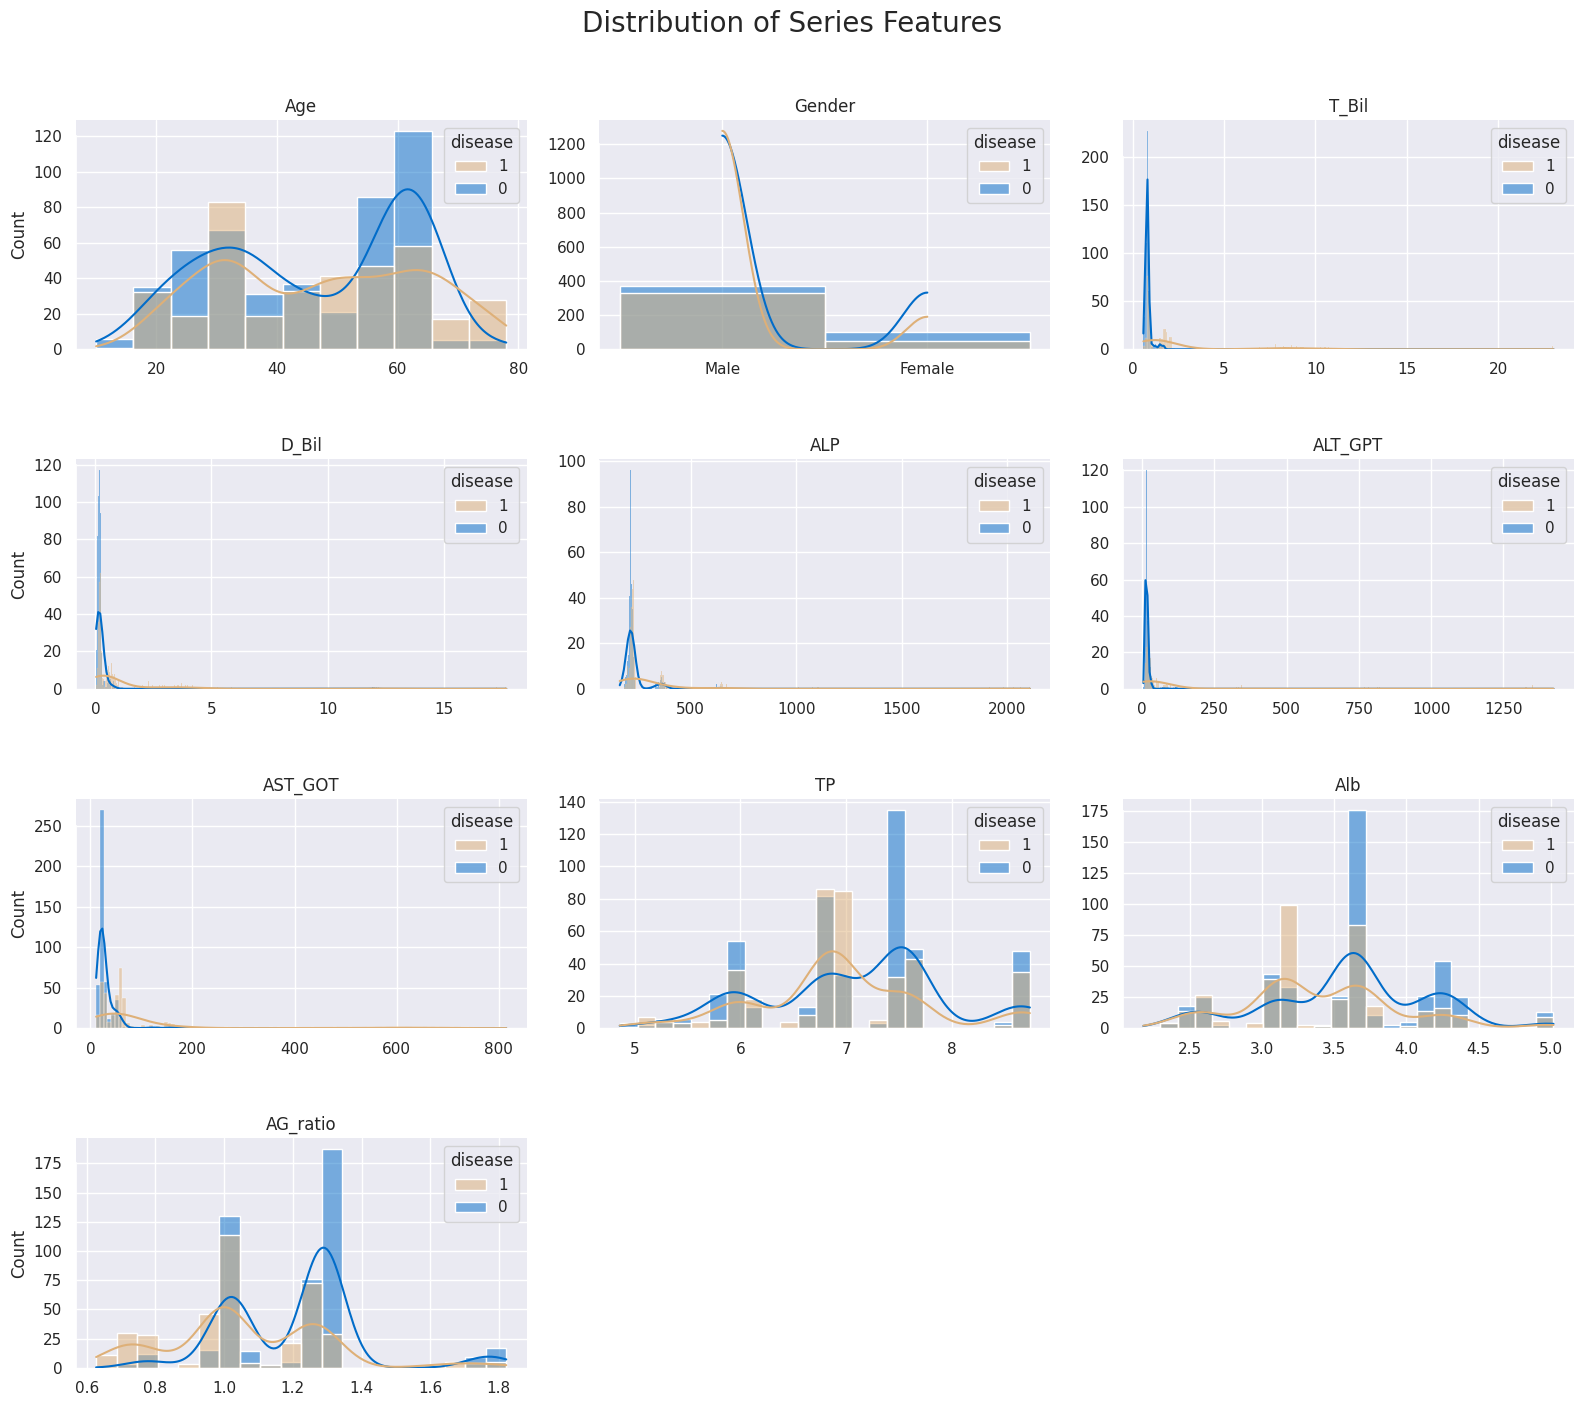

In [283]:
cols = [col for col in train.columns if col not in [""]]
plot_df = train[cols]

fig, ax = plt.subplots(4, 3, figsize=(16, 18))
fig.suptitle("Distribution of Series Features", fontsize=20)

row = 0
col = [0, 1, 2]*4

for i, column in enumerate(plot_df.columns[:-1]):
    if (i != 0) & (i%3 == 0):
        row += 1

    sns.histplot(
        x=column, data=plot_df, ax=ax[row, col[i]],
        hue="disease", hue_order=[1, 0], palette=pal[::-1],
        fill=True, kde=True
    )
    ax[row, col[i]].set(title=f"\n\n{column}", xlabel="", ylabel="Count" if i%3==0 else "")

for i in range(1, 3):
    ax[3, i].set_visible(False)

sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

### 相関係数行列 --

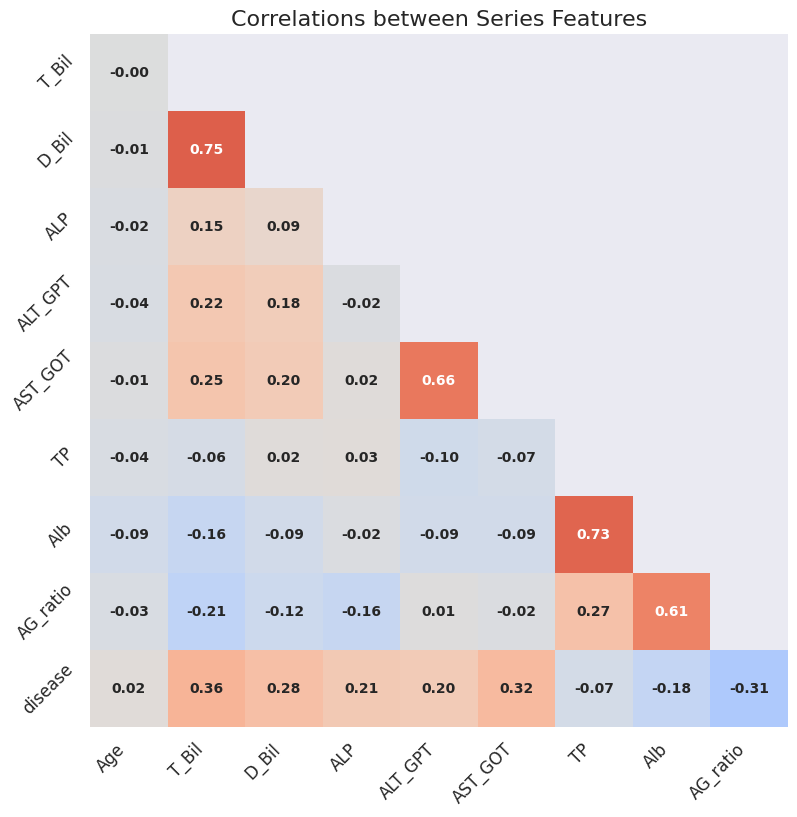

In [284]:
corr = plot_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))[1:, :-1]

corr = corr.iloc[1:, :-1].copy()

fig, ax = plt.subplots(1, 1, figsize=(9, 9))
sns.heatmap(
    corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt=".2f",
    cmap="coolwarm", annot_kws={"fontsize":10, "fontweight":"bold"}, cbar=False
)
ax.tick_params(left=False, bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right", fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=45, fontsize=12)
plt.title("Correlations between Series Features", fontsize=16)
fig.show()

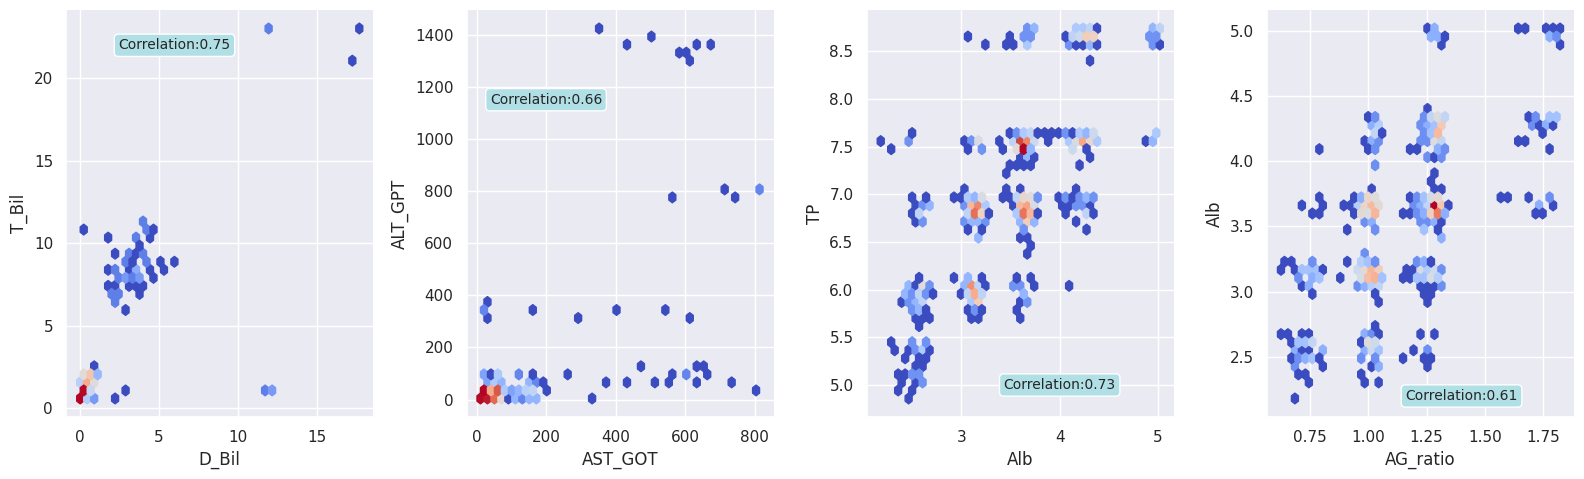

In [285]:
fig, ax = plt.subplots(1, 4, figsize=(16, 5))

ax[0].hexbin(x="D_Bil", y="T_Bil", data=plot_df, bins="log", gridsize=40, cmap="coolwarm")
ax[0].set(xlabel="D_Bil", ylabel="T_Bil")
ax[0].text(
    6, 22, "Correlation:{:.2f}".format(plot_df[["D_Bil", "T_Bil"]].corr().iloc[1, 0]),
    ha="center", va="center", bbox=dict(boxstyle="round, pad=0.3", fc="powderblue"),
    fontsize=10
)

xcol = "AST_GOT"
ycol = "ALT_GPT"
ax[1].hexbin(x=xcol, y=ycol, data=plot_df, bins="log", gridsize=40, cmap="coolwarm")
ax[1].set(xlabel=xcol, ylabel=ycol)
ax[1].text(
    200, 1150, "Correlation:{:.2f}".format(plot_df[[xcol, ycol]].corr().iloc[1, 0]),
    ha="center", va="center", bbox=dict(boxstyle="round, pad=0.3", fc="powderblue"),
    fontsize=10
)

xcol = "Alb"
ycol = "TP"
ax[2].hexbin(x=xcol, y=ycol, data=plot_df, bins="log", gridsize=40, cmap="coolwarm")
ax[2].set(xlabel=xcol, ylabel=ycol)
ax[2].text(
    4, 5, "Correlation:{:.2f}".format(plot_df[[xcol, ycol]].corr().iloc[1, 0]),
    ha="center", va="center", bbox=dict(boxstyle="round, pad=0.3", fc="powderblue"),
    fontsize=10
)

xcol = "AG_ratio"
ycol = "Alb"
ax[3].hexbin(x=xcol, y=ycol, data=plot_df, bins="log", gridsize=40, cmap="coolwarm")
ax[3].set(xlabel=xcol, ylabel=ycol)
ax[3].text(
    1.4, 2.2, "Correlation:{:.2f}".format(plot_df[[xcol, ycol]].corr().iloc[1, 0]),
    ha="center", va="center", bbox=dict(boxstyle="round, pad=0.3", fc="powderblue"),
    fontsize=10
)

sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.99])

### 欠損値の確認

In [286]:
train.isna().sum()

Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    0
disease     0
dtype: int64

## Series Featureでベースライン

### Categoryを変換

In [287]:
train["Gender"] = train["Gender"].map(lambda x: {"Male":0, "Female":1}[x])
test["Gender"] = test["Gender"].map(lambda x: {"Male":0, "Female":1}[x])

### ベースライン作成

In [288]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

folds = 5
seed = 42
run_id = "Lgb_Baseline"

output_path = "./output/" + run_id

if not os.path.exists(output_path):
    os.mkdir(output_path)

In [289]:
from sklearn.metrics import log_loss, roc_auc_score
def Metric(labels, preds):
    #return log_loss(labels, preds)
    return roc_auc_score(labels, preds)

In [290]:
cat_feature = []
num_feature = [col for col in train.columns if col not in ["disease"]]
features = cat_feature + num_feature
label_name = "disease"

In [291]:
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
split = skf.split(train, train[label_name])

oof = pd.DataFrame(train.index, columns=["index"])
oof[label_name] = 0

In [292]:
lgb_params = {
    "objective": "binary",
    "metric": "binary_logloss",

    "max_depth": -1,
    "num_leaves": 64,
    "learning_rate": 0.05,
    "bagging_freq": 5,
    "bagging_fraction": 0.7,
    "feature_fraction": 0.7,

    "num_threads": 16,
}

In [293]:
all_valid_metric, feature_importance = [], []
for fold, (trn_index, val_index) in enumerate(split):
    evals_result_dic = {}
    trn_data = lgb.Dataset(train.loc[trn_index, features], label=train.loc[trn_index, label_name])
    val_data = lgb.Dataset(train.loc[val_index, features], label=train.loc[val_index, label_name])

    model = lgb.train(lgb_params,
        train_set = trn_data,
        num_boost_round = 10000,
        valid_sets = [trn_data, val_data],
        evals_result = evals_result_dic,
        early_stopping_rounds = 2000,
        verbose_eval = -1
    )
    model.save_model(output_path + "/fold%s.ckpt"%fold)

    valid_preds = model.predict(train.loc[val_index, features], num_iterations=model.best_iteration)
    oof.loc[val_index, label_name] = valid_preds

    all_valid_metric.append(Metric(train.loc[val_index, label_name], valid_preds))

    importance_gain = model.feature_importance(importance_type="gain")
    importance_split = model.feature_importance(importance_type="split")
    feature_name = model.feature_name()
    feature_importance.append(
        pd.DataFrame(
            {"feature_name": feature_name,
             "importance_gain": importance_gain,
             "importance_split": importance_split})
    )
feature_importance_df = pd.concat(feature_importance)
feature_importance_df = feature_importance_df.groupby(["feature_name"]).mean().reset_index()
feature_importance_df = feature_importance_df.sort_values(by=["importance_gain"], ascending=False)
feature_importance_df.to_csv(output_path + "/feature_importance.csv", index=False)

global_valid_metric = Metric(train[label_name].values, oof[label_name].values)
oof.to_csv(output_path + "/oof.csv", index=False)


[LightGBM] [Info] Number of positive: 303, number of negative: 377
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1857
[LightGBM] [Info] Number of data points in the train set: 680, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445588 -> initscore=-0.218512
[LightGBM] [Info] Start training from score -0.218512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 2000 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

In [294]:
sub = pd.DataFrame(test.index, columns=["index"])
sub["prediction"] = 0
for fold in range(folds):
    model = lgb.Booster(model_file = output_path + "/fold%s.ckpt"%fold)
    test_preds = model.predict(test[features], num_iteration=model.best_iteration)
    sub["prediction"] += (test_preds / folds)

In [295]:
sub.rename(columns={"index":0, "prediction":0.1}, inplace=True)

In [296]:
sub.to_csv(output_path + "/submission.csv", index=False)

In [297]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(train.loc[val_index, label_name].values, valid_preds))

0.9402295632698768
